In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import geopandas as gpd

from landlab import NetworkModelGrid

from landlab.io.shapefile import read_shapefile

In [2]:
links_fn = '../data/reservoir_network/reservoir_network.shp'
nodes_fn = '../data/reservoir_network_pts/reservoir_network_pts.shp'

nmg = read_shapefile(
    file = links_fn,
    dbf = links_fn.replace('.shp', '.dbf'),
    points_shapefile = nodes_fn,
    points_dbf = nodes_fn.replace('.shp', '.dbf'),
    threshold = 1e-10
)
nmg

<xarray.Dataset>
Dimensions:        (node: 31, link: 43, Two: 2)
Coordinates:
  * node           (node) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: link, Two
Data variables:
    mesh           <U1 'a'
    y_of_node      (node) float64 36.78 36.97 37.41 37.41 ... 42.03 42.22 42.28
    x_of_node      (node) float64 -107.6 -111.5 -108.3 ... -110.1 -109.3 -109.4
    nodes_at_link  (link, Two) int64 1 0 1 2 1 3 1 4 ... 27 25 25 28 25 29 25 30

In [3]:
nmg.at_node.keys()

['min_dist', 'name', 'index_righ', 'lon', 'lat', 'id', 'dist [m]', 'to_id']

In [4]:
# read in elevations
elev_gdf = gpd.read_file("../data/selected_reservoirs/selected_reservoirs_elevation.shp").set_index('DAM_NAME')
elevations = [elev_gdf.loc[name, 'Elevation'] for name in nmg.at_node['name']]  # use name as identifier

In [5]:
nmg.add_field(
    "topographic__elevation",
    elevations,
    at='node',
    units='m',
    clobber=True
)
nmg.add_field(
    "reservoir__abstract_elevation",
    elevations,
    at='node',
    units='m',
    clobber=True
);

In [6]:
# set constant values for stream properties for now
HYDRAULIC_RADIUS = 30.0 # m
MANNINGS_N = 0.001 # -

In [7]:
# initialize fields
nmg.add_field(
    "reservoir__total_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__storage_change",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__release",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__regulated_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__unregulated_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "river__hydraulic_radius",
    np.full_like(nmg.active_links, HYDRAULIC_RADIUS, dtype=float),
    at='link',
    unit='m',
    clobber=True
)
nmg.add_field(
    "river__roughness",
    np.full_like(nmg.active_links, MANNINGS_N, dtype=float),
    at='link',
    unit='-',
    clobber=True
);

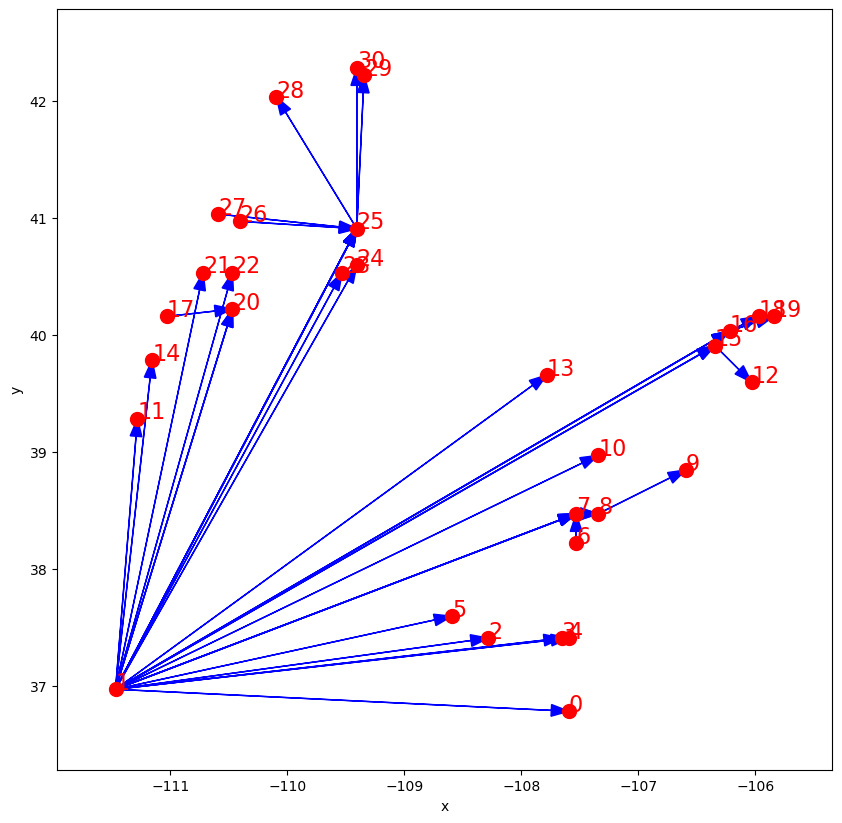

In [8]:
from landlab.plot.graph import plot_graph, plot_links
import matplotlib.pyplot as plt 

f, ax = plt.subplots(figsize=(10, 10))

plot_links(nmg, as_arrow=True, with_id=False) # looks like the link directions are messed up...
plot_graph(nmg, "node", with_id=True)

In [9]:
# creating own slope calculation function, landlab's calc_grad uses default 
# generated length which doesn't work in this case, so have to generate own lengths (get it from generated reservoir network)

# read reservoir_network file
link_gdf = gpd.read_file("../data/reservoir_network/reservoir_network.shp")#.set_index('from_name')
link_gdf.head()

# scratch section below
# [link_gdf.loc[from_name, 'length'] for from_name in nmg.at_link['from_name']]
# for from_name, to_name in zip(nmg.at_link['from_name'], nmg.at_link['to_name']):
#     link_gdf.loc[(link_gdf['from_name']==from_name), 'length'].median()   # there seems to be a bug in the network generation code that returns multiple link lengths for the same pair of reservoirs. Fix this later, for now  use the median length of the returned values

# rewrite the above logic in a succint manner
lengths = [link_gdf.loc[(link_gdf['from_name']==from_name), 'length'].median() for from_name, to_name in zip(nmg.at_link['from_name'], nmg.at_link['to_name'])]

slope = np.divide(
    np.abs(
        nmg.at_node['topographic__elevation'][nmg.node_at_link_head] - nmg.at_node['topographic__elevation'][nmg.node_at_link_tail]
    ), lengths
)

nmg.add_field(
    "river__slope",
    slope,
    at='link',
    unit='m/m',
    clobber=True
)
nmg.add_field(
    "river__length",
    lengths,
    at='link',
    unit='m',
    clobber=True
);

In [10]:
# add link river storage. Use an assumption - 
#   river is a half cylinder, with R being the hydraulic radius.
#   R = A/P; A = R * P ; where P is the wetted perimeter.
#   if river is a half cylinder, P = pi * R; 
#   A = pi * R^2
#   Storage = A * Length

A = np.pi * np.square(nmg.at_link["river__hydraulic_radius"])
S = A * nmg.at_link["river__length"]
storage_multiplier = 0.2 # fraction full in January

nmg.add_field(
    "river__storage",
    S * 0.1,
    at='link',
    unit='m3',
    clobber=True
);

Now that the input fields are defined, let's load the in-situ data.

In [11]:
import xarray as xr

data = xr.open_dataset('../data/TS_2015.nc')
data

<xarray.Dataset>
Dimensions:      (date: 366, DAM_NAME: 31)
Coordinates:
  * date         (date) datetime64[ns] 2015-01-01 2015-01-02 ... 2016-01-01
  * DAM_NAME     (DAM_NAME) object 'Big Sandy Dike' ... 'Willow Creek'
Data variables: (12/13)
    DAM_ID       (DAM_NAME, date) float64 ...
    storage      (DAM_NAME, date) float64 ...
    inflow       (DAM_NAME, date) float64 ...
    outflow      (DAM_NAME, date) float64 ...
    evaporation  (DAM_NAME, date) float64 ...
    elevation    (DAM_NAME, date) float64 ...
    ...           ...
    AGENCY_COD   (DAM_NAME) object ...
    LONG         (DAM_NAME) float64 ...
    LAT          (DAM_NAME) float64 ...
    TS_START     (DAM_NAME) datetime64[ns] ...
    TS_END       (DAM_NAME) datetime64[ns] ...
    INCONSISTE   (DAM_NAME) float64 ...

In [12]:
# convert units to m3 or m3/day
data['inflow'] = data['inflow'] * (24 * 60 * 60)
data['storage'] = data['storage'] * (24 * 60 * 60)
data['outflow'] = data['outflow'] * (24 * 60 * 60)

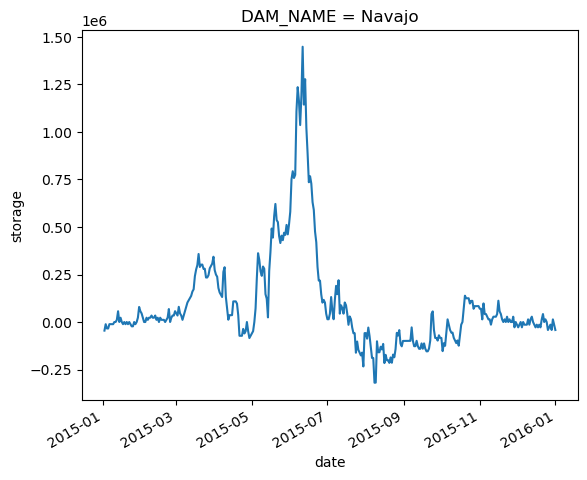

In [13]:
# add storage change
data = xr.merge([data.storage.diff(dim="date").rename("storage_change"), data])
data.storage.diff(dim="date").sel(DAM_NAME="Navajo").plot()

In [14]:
time = data.date
time

<xarray.DataArray 'date' (date: 366)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2015-12-30T00:00:00.000000000',
       '2015-12-31T00:00:00.000000000', '2016-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 2015-01-01 2015-01-02 ... 2016-01-01

In [15]:
inflows = np.array([data['inflow'].sel(DAM_NAME=name).data for name in nmg.at_node['name']]).T
storage_changes = np.array([data['storage_change'].sel(DAM_NAME=name).data for name in nmg.at_node['name']]).T

Now that we have the times, inflows, storage_changes, lets run the model

In [16]:
from reservoirnetwork.reservoir_component import StreamflowRegulation

In [17]:
nmg.at_node.keys()

['min_dist',
 'name',
 'index_righ',
 'lon',
 'lat',
 'id',
 'dist [m]',
 'to_id',
 'topographic__elevation',
 'reservoir__abstract_elevation',
 'reservoir__total_inflow',
 'reservoir__storage_change',
 'reservoir__release',
 'reservoir__regulated_inflow',
 'reservoir__unregulated_inflow']

In [18]:
node_data = {
    "reservoir__regulated_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__unregulated_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__release": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__total_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__upstream_storage_change": np.full((len(time), len(nmg.nodes)), np.nan)
}
link_data = {
    "river__storage": np.full((len(time), len(nmg.active_links)), np.nan),
    "river__regulated_flow": np.full((len(time), len(nmg.active_links)), np.nan),
    "river__release_inflow": np.full((len(time), len(nmg.active_links)), np.nan)
}

last_release = [data['outflow'].sel(DAM_NAME=name).isel(date=1).data for name in nmg.at_node['name']]

nmg.at_node['reservoir__release'] = last_release

sr = StreamflowRegulation(nmg)

In [19]:
inflows[0].shape

(31,)

In [20]:
for idx, t, inflow, storage_change in zip(
    range(len(time[1:])),   # skip first value since it will be nan
    time[1:], 
    inflows[1:], 
    storage_changes[1:]
):
    # grid.at_node['reservoir__release'] = last_release
    sr.run_one_step(t, inflow, storage_change)
    
    # save node data
    
    # for node_id in enumerate(grid.nodes):
    for key in node_data:
        node_data[key][idx] = nmg.at_node[key]
    # for node_id in enumerate(grid.nodes):
    for key in link_data:
        link_data[key][idx] = nmg.at_link[key]

In [21]:
# convert the resulting data to a Dataset for visualization
import pandas as pd
import xarray as xr

node_ds = []

for var in node_data:
    da = xr.DataArray(
        node_data[var].T, 
        dims = ["DAM_NAME", "date"],
        coords=dict(
            DAM_NAME = nmg.at_node["name"],
            date = time
        ),
        name = var
    )
    node_ds.append(da)

node_ds = xr.merge(node_ds)
node_ds


link_ds = []

for var in link_data:
    da = xr.DataArray(
        link_data[var].T, 
        dims = ["FROM_DAM_NAME", "date"],
        coords=dict(
            FROM_DAM_NAME = nmg.at_link["from_name"],
            date = time
        ),
        name = var
    )
    link_ds.append(da)

link_ds = xr.merge(link_ds)
link_ds

<xarray.Dataset>
Dimensions:                (FROM_DAM_NAME: 43, date: 366)
Coordinates:
  * FROM_DAM_NAME          (FROM_DAM_NAME) <U20 'Navajo' ... 'Big Sandy Dike'
  * date                   (date) datetime64[ns] 2015-01-01 ... 2016-01-01
Data variables:
    river__storage         (FROM_DAM_NAME, date) float64 1.28e+08 ... nan
    river__regulated_flow  (FROM_DAM_NAME, date) float64 1.098e+05 ... nan
    river__release_inflow  (FROM_DAM_NAME, date) float64 3.848e+05 ... nan

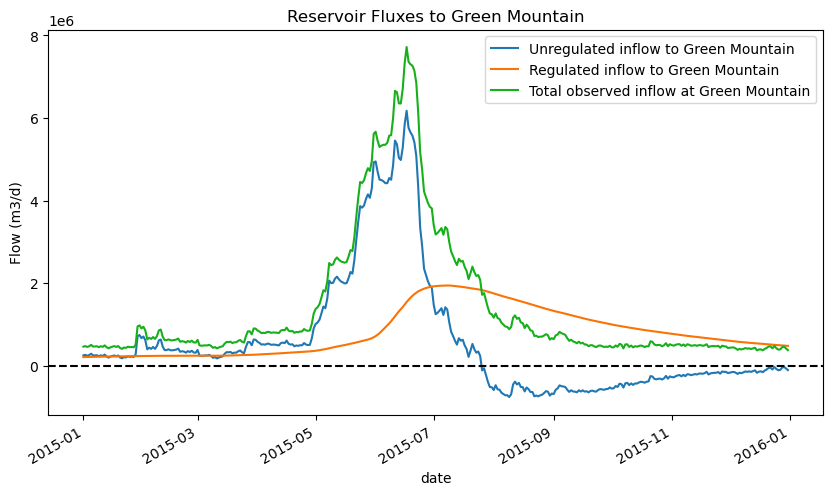

In [22]:
# Plot Upstream and Downstream fluxes
import matplotlib.pyplot as plt

# upstream = "Soldier Creek"
# downstream = "Morrow Point"
# downstream = "Williams Fork"
downstream = "Green Mountain"
# downstream = "Dillon"
# downstream = "Glen Canyon"

f, ax = plt.subplots(figsize=(10, 5))

node_ds['reservoir__unregulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Unregulated inflow to {downstream}')
node_ds['reservoir__regulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Regulated inflow to {downstream}', color='xkcd:orange')
node_ds['reservoir__total_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Total observed inflow at {downstream}', color='xkcd:green')
ax.axhline(0, linestyle='--', color='k')
# node_ds['reservoir__release'].sel(DAM_NAME=upstream).plot(ax=ax, label='Release from upstream dam', color='xkcd:black', linestyle='-.')
ax.set_title(f"Reservoir Fluxes to {downstream}")
ax.set_ylabel(f"Flow (m3/d)")
ax.legend()

savep = f"../results/reservoir_fluxes/from_{downstream.lower().replace(' ', '_')}.png"
f.savefig(savep)

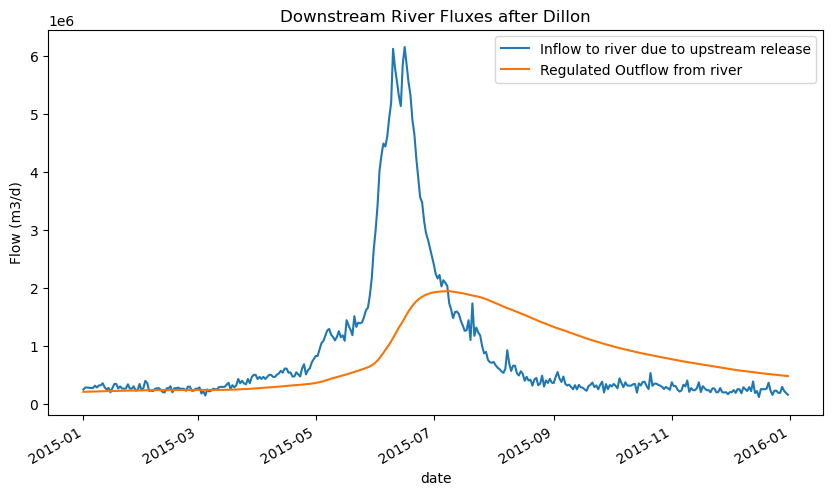

In [23]:
# Plot Upstream and Downstream fluxes
import matplotlib.pyplot as plt

upstream = "Dillon"

f, ax = plt.subplots(figsize=(10, 5))

link_ds['river__release_inflow'].sel(FROM_DAM_NAME=upstream).plot(ax=ax, label='Inflow to river due to upstream release')
link_ds['river__regulated_flow'].sel(FROM_DAM_NAME=upstream).plot(ax=ax, label='Regulated Outflow from river', color='xkcd:orange')
# link_ds['reservoir__total_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label='Total inflow at downstream', color='xkcd:green')
# link_ds['reservoir__release'].sel(DAM_NAME=upstream).plot(ax=ax, label='Release from upstream dam', color='xkcd:black', linestyle='-.')
ax.set_title(f"Downstream River Fluxes after {upstream}")
ax.legend()

ax.set_ylabel("Flow (m3/d)")

savep = f"../results/river_fluxes/from_{upstream.lower().replace(' ', '_')}.png"
f.savefig(savep)

# Notes
- Assumption that Unregulated flow and Regulated flow can be partitioned at reservoir contradict with the assumption of the river flow model. The outflow from river depends on the storage of the river (higher storage, more outflow); and the "unregulated flow" that will be coming into the reservoir will also increase the storage of the river, leading to higher flows. Here we see that the river flow wanes after a release event, which should be more sharp, because of increasing storage of river due to unregulated flow. 
    - Example: ![](../results/river_fluxes/from_willow_creek.png)
